# Radiomics analysis

In [181]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
import fastcluster

from scipy import stats
from sklearn.feature_selection import VarianceThreshold, mutual_info_classif, f_classif
from statsmodels.stats.multitest import fdrcorrection, multipletests

ds_path = "../study/stats/datasetRadiomics.csv"

In [2]:
df = pd.read_csv(ds_path, index_col="ID")
df.shape

[roi_name]\_[metric]\_[image]\_[feature] 

In [40]:
def separateDFs(df, which="resp"):
    y1 = df[which]
    X = df.drop(["resp", "respPart"], axis=1)
    print(X.shape)

    a = X.isna().any(axis=0)
    # X1 is the first ds
    X1 = X.drop(a[a==True].index, axis=1)

    print(X1.shape)

    X2_1 = X.loc[:, a==True].drop("VNSLC_16")
    b = X2_1.isna().any(axis=0)
    # X2 is the second ds
    X2 = X2_1.drop(b[b==True].index, axis=1)
    y2 = y1.drop("VNSLC_16")
    print(X2.shape)

    # X3 is the third ds
    X3 = X2_1.loc[:, b==True].drop("VNSLC_19")
    y3 = y2.drop("VNSLC_19")
    print(X3.shape)

    return X1, y1, X2, y2, X3, y3

# Filtering

##### Variance threshold

In [186]:
X1, y1, X2, y2, X3, y3 = separateDFs(df)

(19, 1512456)
(19, 891272)
(18, 594176)
(17, 27008)


In [187]:
X_selected = []

for X in [X1, X2, X3]:
    varThresh = VarianceThreshold()
    varThresh.fit_transform(X)
    selected_feature_indices = varThresh.get_support(indices=True)
    X_selected.append(X.iloc[:, selected_feature_indices])

df_selected = pd.concat([df["resp"], df["respPart"], X_selected[0], X_selected[1], X_selected[2]], axis=1)
df_selected.shape

(19, 1130288)

##### Mannwhiten

In [323]:
X_resp = df_selected[df["resp"]==1]
X_non = df_selected[df["resp"]==0]
res_mannwhitneyu = pd.DataFrame(stats.mannwhitneyu(X_resp, X_non, nan_policy="omit").pvalue, index=df_selected.columns)

(19, 52017)

In [342]:
temp = res_mannwhitneyu>0.05
features_to_remove = temp[temp == True].dropna().index
df_mannwhiten = df_selected.drop(features_to_remove,axis=1)
df_mannwhiten.shape

(19, 52017)

##### Kruskal

In [343]:
X_resp= df_mannwhiten[df["respPart"]==2]
X_respPart = df_mannwhiten[df["respPart"]==1]
X_non = df_mannwhiten[df["respPart"]==0]
res_kruskal = pd.DataFrame(stats.kruskal(X_non, X_respPart, X_resp, nan_policy="omit", axis=0).pvalue, index=df_mannwhiten.columns)

In [345]:
temp = res_kruskal>0.05
features_to_remove = temp[temp == True].dropna().index
df_kruskal = df_mannwhiten.drop(features_to_remove,axis=1)
df_kruskal.shape

(19, 26490)

##### Outlier removal

In [360]:
features_to_remove = []

for i in [0, 1, 2]:
    df_curr = df_kruskal[df["respPart"]==i]
    z_scores_abs = abs((df_curr - df_curr.mean())/df_curr.std())

    features_with_outliers = (z_scores_abs >= 2).any(axis=0)
    features_to_remove_curr = features_with_outliers[features_with_outliers == True].dropna().index

    features_to_remove = [*features_to_remove, *features_to_remove_curr]

df_outliers = df_kruskal.drop(features_to_remove, axis=1)
df_outliers.shape

(19, 14563)

##### Kurtosis filtering

In [371]:
res_kurtosis = pd.DataFrame(stats.kurtosis(df_outliers, axis=0, bias=False, nan_policy="omit"), index=df_outliers.columns)
temp = (res_kurtosis>2) | (res_kurtosis<-0.5)
features_to_remove = temp[temp == True].dropna().index
df_kurtosis = df_outliers.drop(features_to_remove,axis=1)
df_kurtosis = pd.concat([df[["resp", "respPart"]], df_kurtosis], axis=1)
df_kurtosis.shape

(19, 6933)

In [372]:
df_kurtosis.to_csv("../study/stats/datasetRadiomicsFiltered.csv")

In [386]:
df_kurtosis = pd.read_csv("../study/stats/datasetRadiomicsFiltered.csv", index_col="ID")
df_kurtosis.shape

(19, 6933)

# Clustering by region

In [376]:
roi_name = [
    "Thalamus",
    "Hippocampus",
    "Amygdala",
    "Accumbens-area",
    "Putamen", 
    "Pallidum",
    "Caudate",
]

tract_name = [
    "acomm",
    "cc.bodyc",
    "cc.bodyp",
    "cc.bodypf",
    "cc.bodypm",
    "cc.bodyt",
    "cc.genu",
    "cc.rostrum",
    "cc.splenium",
    "lh.af",
    "lh.ar",
    "lh.atr",
    "lh.cbd",
    "lh.cbv",
    "lh.cst",
    "lh.emc",
    "lh.fat",
    "lh.fx",
    "lh.ilf",
    "lh.mlf",
    "lh.or",
    "lh.slf1",
    "lh.slf2",
    "lh.slf3",
    "lh.uf",
    "mcp",
    "lh.af",
    "rh.ar",
    "rh.atr",
    "rh.cbd",
    "rh.cbv",
    "rh.cst",
    "rh.emc",
    "rh.fat",
    "rh.fx",
    "rh.ilf",
    "rh.mlf",
    "rh.or",
    "rh.slf1",
    "rh.slf2",
    "rh.slf3",
    "rh.uf",
    "mcp"
]

In [382]:
def getDF(df, feature):
    df.drop(["resp", "respPart"], axis=1)
    df_filtered = df.filter(regex=feature)
    areNaN = df_filtered.isna().any(axis=1)
    to_remove = areNaN[areNaN == True].index
    return df_filtered.drop(to_remove), to_remove

In [383]:
lut = dict(zip([0, 1, 2], "ryg"))
row_colors = df_kurtosis["respPart"].map(lut)

image_types = {
    "original"      : "blue",
    "exponential"   : "orange",
    "gradient"      : "green",
    "lbp-2D"        : "red",
    "lbp-3D"        : "purple",
    "log"           : "brown",
    "logarithm"     : "pink",
    "square"        : "gray",
    "squareroot"    : "olive",
    "wavelet"       : "cyan"
}

def mapping_func(v):
    for image_type in lut.keys():
        if image_type in v:
            return lut[image_type]
    return "k"

lut = image_types
col_colors_image = pd.DataFrame(df_kurtosis.columns.map(mapping_func)).T
col_colors_image.columns = df_kurtosis.columns
col_colors_image = col_colors_image

metrics = {
    "FA"    : "red",
    "AD"    : "yellow",
    "RD"    : "yellow",
    "MD"    : "yellow",
    "icvf"  : "blue",
    "odi"   : "red",
    "fextra": "blue",
    "fiso"  : "green" ,
    "wFA"   : "red",
    "wMD"   : "yellow",
    "wAD"   : "yellow",
    "wRD"   : "yellow",
    "frac_csf": "green",
    "wfvf"  : "red",
    "fvf_tot": "red",
    "frac_csf":"green",
}

lut = metrics
col_colors_metrics = pd.DataFrame(df_kurtosis.columns.map(mapping_func)).T
col_colors_metrics.columns = df_kurtosis.columns
col_colors_metrics = col_colors_metrics

col_colors = pd.concat([col_colors_image, col_colors_metrics], axis=0, ignore_index=True)
col_colors.index = ["image_type", "model_type"]

In [384]:
method = "average"

if not os.path.isdir(f"../imgs/clustering/roi/"):
    os.mkdir(f"../imgs/clustering/roi/")

if not os.path.isdir(f"../imgs/clustering/roi/{method}/"):
    os.mkdir(f"../imgs/clustering/roi/{method}/")

for mask in roi_name:
    for side in ["Left", "Right"]:
        # print(side, mask)

        regex = f"{side}-{mask}"
        df, to_remove = getDF(df_kurtosis, regex)
        col_colors_filtered = col_colors.filter(regex=regex).T

        sns.clustermap(df, row_colors=row_colors.drop(to_remove), col_colors=col_colors_filtered, z_score=1, method=method, robust=True, cbar_pos=None, xticklabels=False)
        plt.savefig(f"../imgs/clustering/roi/{method}/{mask}-{side}-{method}.png")

        del df
        del col_colors_filtered
        plt.close()

for mask in tract_name:
    # print(mask)

    regex = f"{mask}"
    df, to_remove = getDF(df_kurtosis, regex)
    col_colors_filtered = col_colors.filter(regex=regex).T

    sns.clustermap(df, row_colors=row_colors.drop(to_remove), col_colors=col_colors_filtered, z_score=1, method=method, robust=True, cbar_pos=None, xticklabels=False)
    mask_fields = mask.split(".")
    if len(mask_fields) == 1:
        plt.savefig(f"../imgs/clustering/roi/{method}/{mask}-{method}.png")
    else:
        plt.savefig(f"../imgs/clustering/roi/{method}/{mask_fields[1]}-{mask_fields[0]}-{method}.png")

    del df
    del col_colors_filtered
    plt.close()

/home/michele/anaconda3/envs/pyRadiomics/lib/python3.9/site-packages/seaborn/matrix.py:615: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  ax.set_xlim(0, max_dependent_coord * 1.05)


ValueError: negative dimensions are not allowed

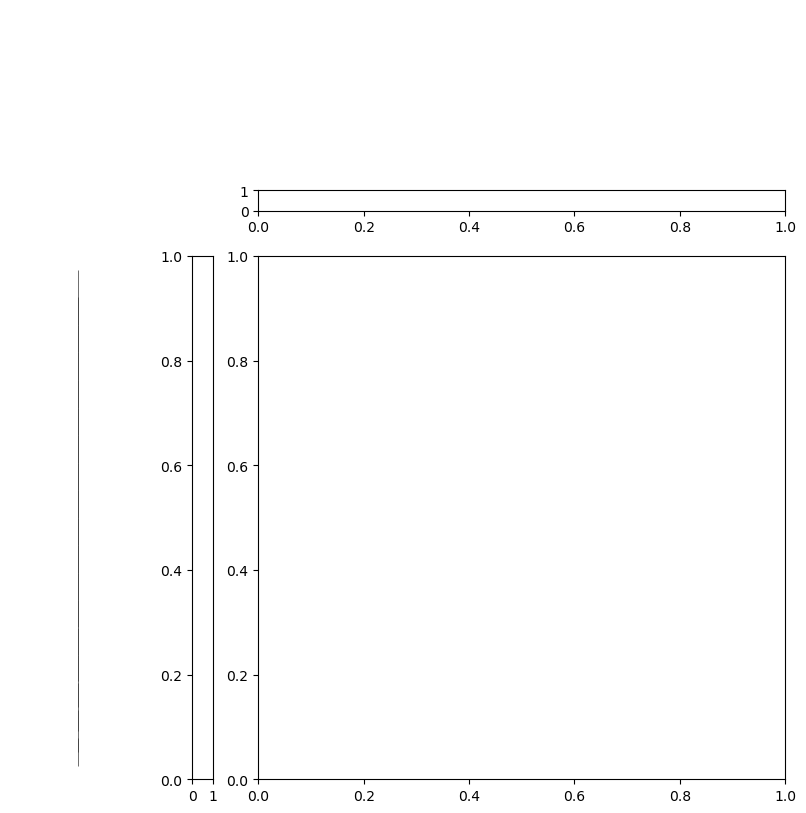

In [385]:
method = "average"

if not os.path.isdir(f"../imgs/clustering/metrics/"):
    os.mkdir(f"../imgs/clustering/metrics/")

if not os.path.isdir(f"../imgs/clustering/metrics/{method}/"):
    os.mkdir(f"../imgs/clustering/metrics/{method}/")

for metric in metrics.keys():
    for image_type in image_types.keys():
        regex = f"{metric}_{image_type}"
        df, to_remove = getDF(df_kurtosis, regex)
        col_colors_filtered = col_colors.filter(regex=regex).T

        sns.clustermap(df, row_colors=row_colors.drop(to_remove), col_colors=col_colors_filtered, z_score=1, method=method, robust=True, cbar_pos=None, xticklabels=False)

        plt.savefig(f"../imgs/clustering/metrics/{method}/{metric}_{image_type}.png")
        
        del df
        del col_colors_filtered
        plt.close()